# Customer Segmentation

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 1. Import Libraries and Load Data

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import warnings
import xlrd
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette('husl')



## 2. Data Loading and Initial Inspection

In [4]:
# Load the dataset
df = pd.read_csv('Mall_Customers.csv')

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset shape: (200, 5)

First 5 rows:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
# Data information and summary statistics
print("Dataset Info:")
print(df.info())
print("\n" + "="*50 + "\n")

print("Summary Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


Summary Statistics:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [6]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print("\nTotal missing values:", df.isnull().sum().sum())

# Check unique values in categorical columns
print("\nUnique values in Gender:", df['Gender'].unique())
print("Gender distribution:")
print(df['Gender'].value_counts())

Missing values per column:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Total missing values: 0

Unique values in Gender: ['Male' 'Female']
Gender distribution:
Gender
Female    112
Male       88
Name: count, dtype: int64


## 3. Data Cleaning and Preprocessing

### 3.1 Feature Selection and Encoding

In [7]:
# Create a copy for preprocessing
df_processed = df.copy()

# Drop CustomerID as it's just a unique identifier with no analytical value
df_processed = df_processed.drop('CustomerID', axis=1)

# Encode Gender (Male=0, Female=1) for potential use in clustering
df_processed['Gender_Encoded'] = df_processed['Gender'].map({'Male': 0, 'Female': 1})

print("Features after preprocessing:")
print(df_processed.columns.tolist())
print("\nProcessed dataset shape:", df_processed.shape)

# Display first few rows of processed data
df_processed.head()

Features after preprocessing:
['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Encoded']

Processed dataset shape: (200, 5)


,Gender,Age,Annual Income (k$),Spending Score (1-100),Gender_Encoded
0,Male,19,15,39,0
1,Male,21,15,81,0
2,Female,20,16,6,1
3,Female,23,16,77,1
4,Female,31,17,40,1


### 3.2 Feature Scaling

Clustering algorithms are sensitive to feature scales. We'll standardize features to have mean=0 and std=1.

In [8]:
# Select features for clustering (focusing on Age, Income, and Spending Score)
# We'll exclude Gender for primary analysis but can include it later for comparison
features_for_clustering = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Initialize and fit the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_processed[features_for_clustering])

print(f"Original features shape: {df_processed[features_for_clustering].shape}")
print(f"Scaled features shape: {X_scaled.shape}")
print("\nScaled features mean (should be ~0):")
print(np.mean(X_scaled, axis=0))
print("\nScaled features std (should be ~1):")
print(np.std(X_scaled, axis=0))

Original features shape: (200, 3)
Scaled features shape: (200, 3)

Scaled features mean (should be ~0):
[-1.02140518e-16 -2.13162821e-16 -1.46549439e-16]

Scaled features std (should be ~1):
[1. 1. 1.]


## 4. Exploratory Data Analysis (EDA)

### 4.1 Distribution Analysis

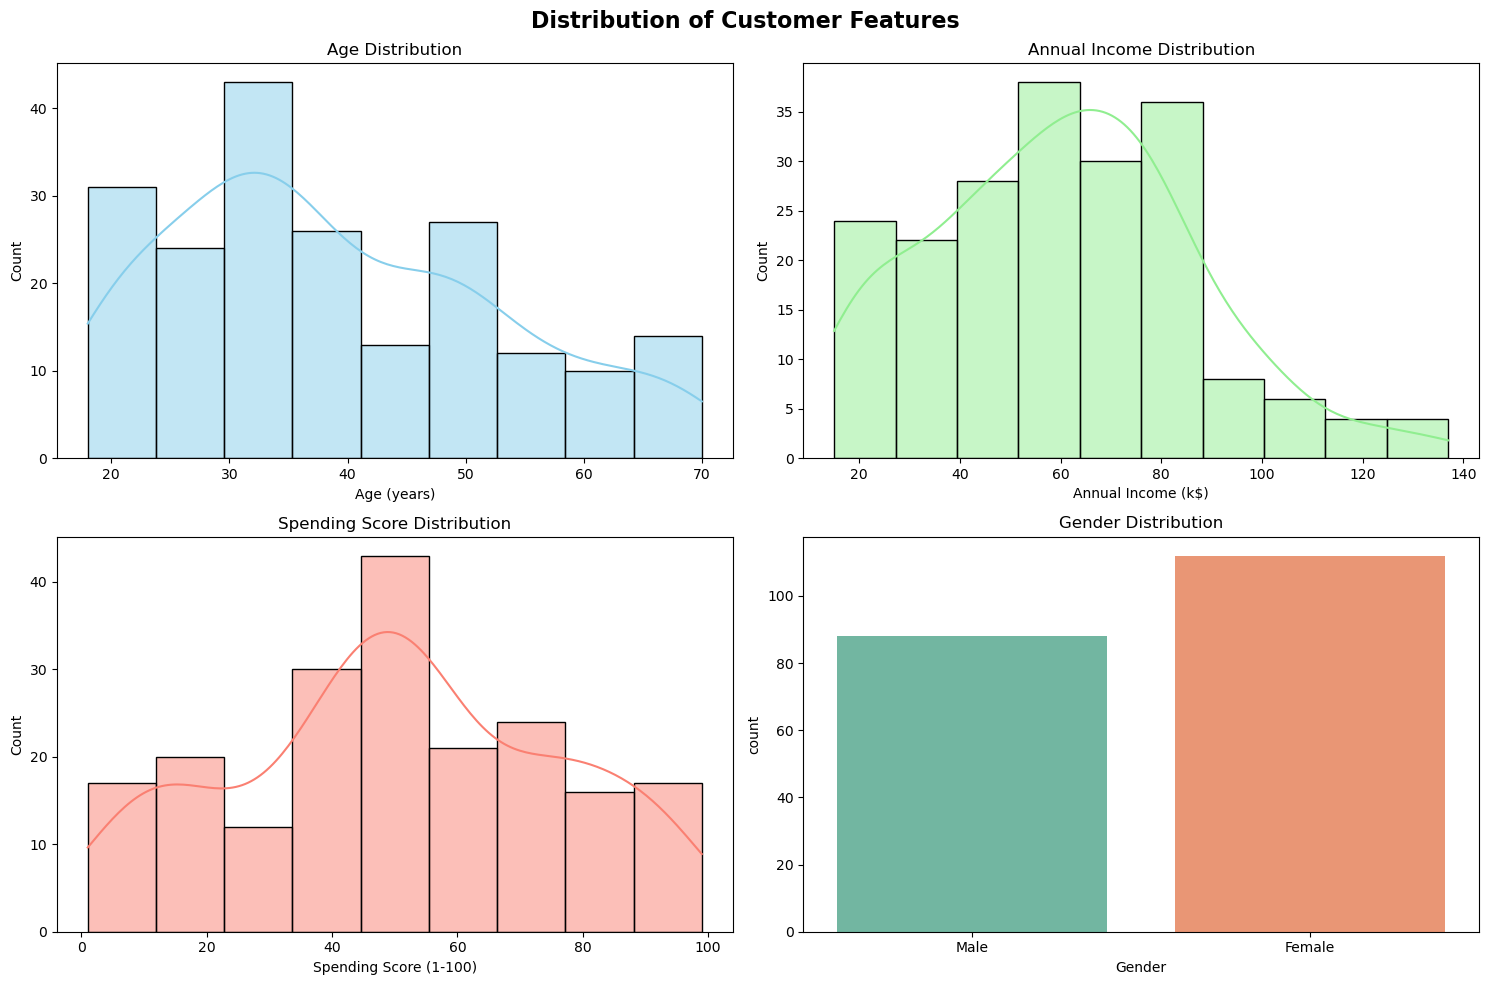

Key Statistics:
Age range: 18 - 70 years (mean: 38.9)
Income range: $15k - $137k (mean: $60.6k)
Spending Score range: 1 - 99 (mean: 50.2)


In [9]:
# Create histograms for each feature
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Customer Features', fontsize=16, fontweight='bold')

# Age distribution
sns.histplot(data=df_processed, x='Age', kde=True, ax=axs[0,0], color='skyblue')
axs[0,0].set_title('Age Distribution')
axs[0,0].set_xlabel('Age (years)')

# Annual Income distribution
sns.histplot(data=df_processed, x='Annual Income (k$)', kde=True, ax=axs[0,1], color='lightgreen')
axs[0,1].set_title('Annual Income Distribution')
axs[0,1].set_xlabel('Annual Income (k$)')

# Spending Score distribution
sns.histplot(data=df_processed, x='Spending Score (1-100)', kde=True, ax=axs[1,0], color='salmon')
axs[1,0].set_title('Spending Score Distribution')
axs[1,0].set_xlabel('Spending Score (1-100)')

# Gender distribution
sns.countplot(data=df_processed, x='Gender', ax=axs[1,1], palette='Set2')
axs[1,1].set_title('Gender Distribution')
axs[1,1].set_xlabel('Gender')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Key Statistics:")
print(f"Age range: {df_processed['Age'].min()} - {df_processed['Age'].max()} years (mean: {df_processed['Age'].mean():.1f})")
print(f"Income range: ${df_processed['Annual Income (k$)'].min()}k - ${df_processed['Annual Income (k$)'].max()}k (mean: ${df_processed['Annual Income (k$)'].mean():.1f}k)")
print(f"Spending Score range: {df_processed['Spending Score (1-100)'].min()} - {df_processed['Spending Score (1-100)'].max()} (mean: {df_processed['Spending Score (1-100)'].mean():.1f})")

### 4.2 Correlation and Relationship Analysis

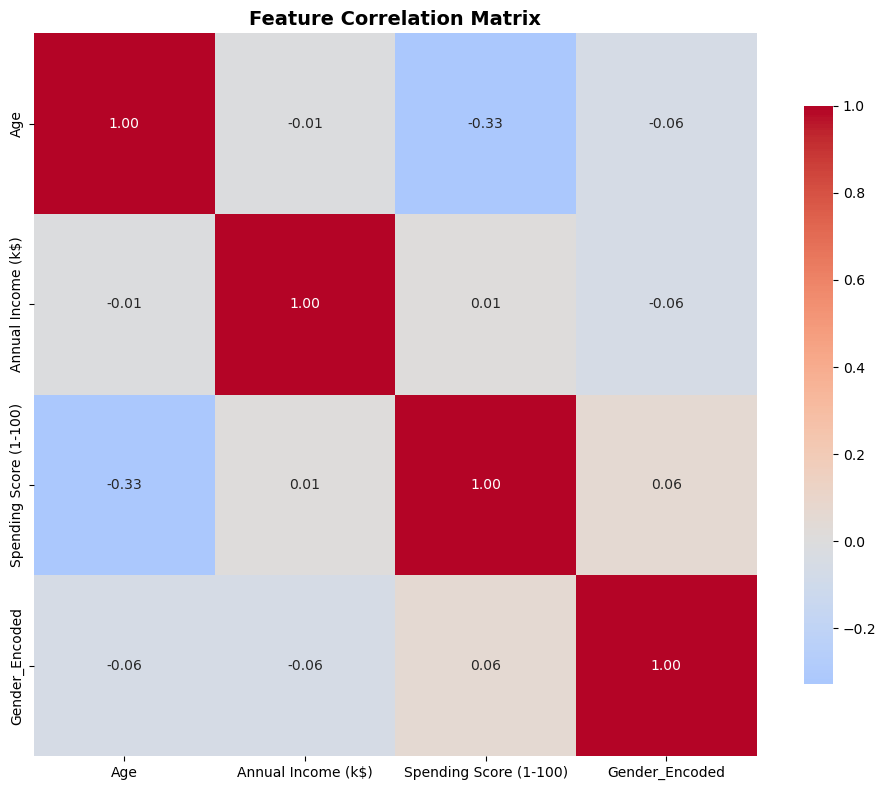

Correlation Insights:
- Income and Spending Score correlation: 0.010


In [10]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Encoded']
corr_matrix = df_processed[correlation_features].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': .8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Correlation Insights:")
print("- Income and Spending Score correlation:", f"{corr_matrix.loc['Annual Income (k$)', 'Spending Score (1-100)']:.3f}")

<Figure size 1200x1000 with 0 Axes>

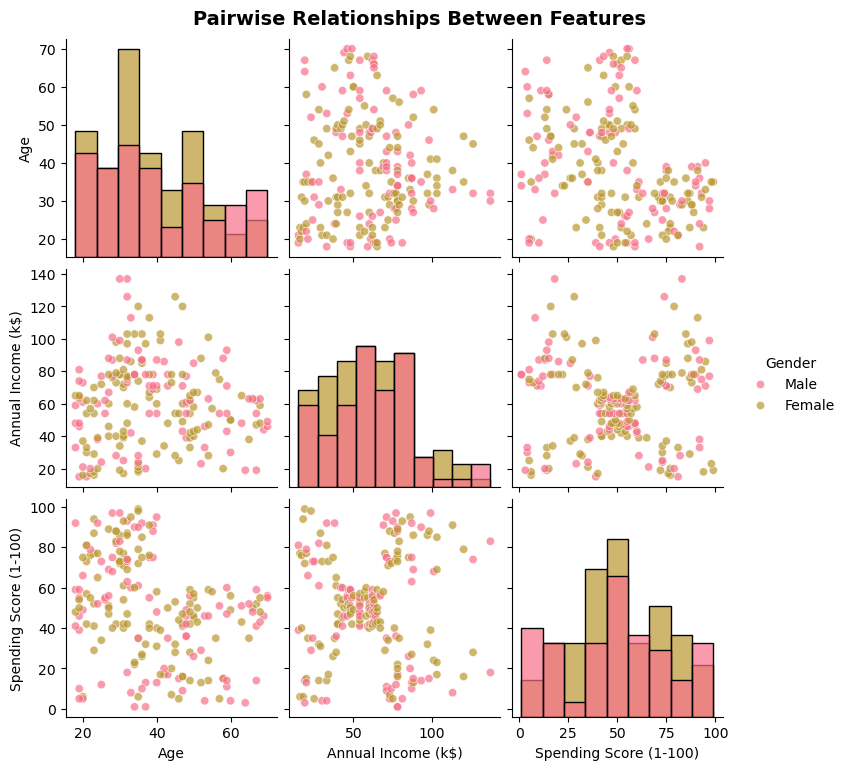

In [11]:
# Pairplot to visualize relationships
plt.figure(figsize=(12, 10))
plot_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
pairplot_df = df_processed[plot_features + ['Gender']].copy()

g = sns.pairplot(pairplot_df, hue='Gender', diag_kind='hist', 
                 plot_kws={'alpha': 0.7}, diag_kws={'alpha': 0.7})
g.figure.suptitle('Pairwise Relationships Between Features', y=1.02, fontsize=14, fontweight='bold')
plt.show()

### 4.3 Key Scatter Plot: Income vs Spending Score

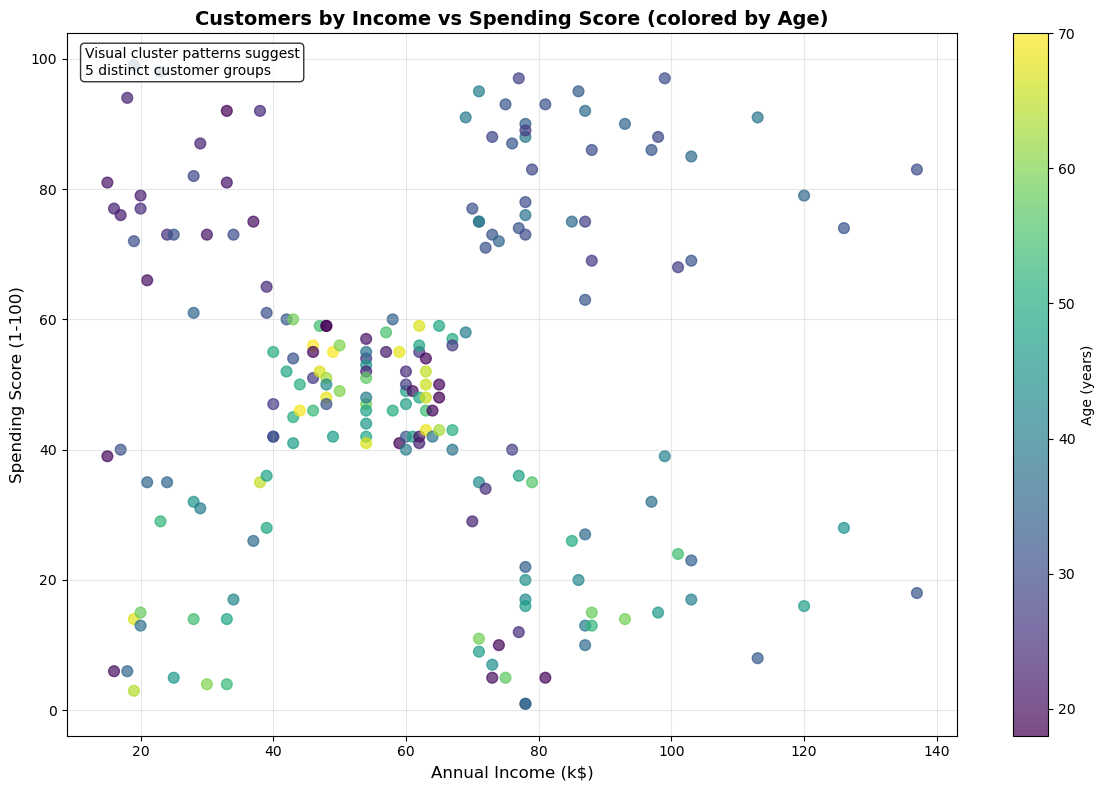

In [12]:
# Create the most important scatter plot for clustering intuition
plt.figure(figsize=(12, 8))

# Main scatter plot
scatter = plt.scatter(df_processed['Annual Income (k$)'], 
                     df_processed['Spending Score (1-100)'], 
                     c=df_processed['Age'], 
                     s=60, alpha=0.7, cmap='viridis')

plt.colorbar(scatter, label='Age (years)')
plt.title('Customers by Income vs Spending Score (colored by Age)', fontsize=14, fontweight='bold')
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add some analysis text
plt.text(0.02, 0.98, 'Visual cluster patterns suggest\n5 distinct customer groups', 
         transform=plt.gca().transAxes, fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()



Visual Analysis:
- Clear visual separation suggests multiple customer segments
- High income + high spending: Premium customers
- Low income + low spending: Budget customers"
- High income + low spending: Conservative high earners
- Moderate income + high spending: Aspirational spenders
- Age appears to add another dimension to the segmentation

## 5. K-Means Clustering Implementation

### 5.1 Determining Optimal Number of Clusters

In [13]:
# Elbow Method - Calculate WCSS for different k values
wcss = []
silhouette_scores = []
k_range = range(1, 11)

print("Calculating optimal number of clusters...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
    # Calculate silhouette score (only for k >= 2)
    if k >= 2:
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(X_scaled, labels)
        silhouette_scores.append(silhouette_avg)
        print(f"k={k}, silhouette_score={silhouette_avg:.3f}")



Calculating optimal number of clusters...
k=2, silhouette_score=0.335
k=3, silhouette_score=0.358
k=4, silhouette_score=0.404
k=5, silhouette_score=0.417
k=6, silhouette_score=0.428
k=7, silhouette_score=0.417
k=8, silhouette_score=0.408
k=9, silhouette_score=0.418
k=10, silhouette_score=0.407


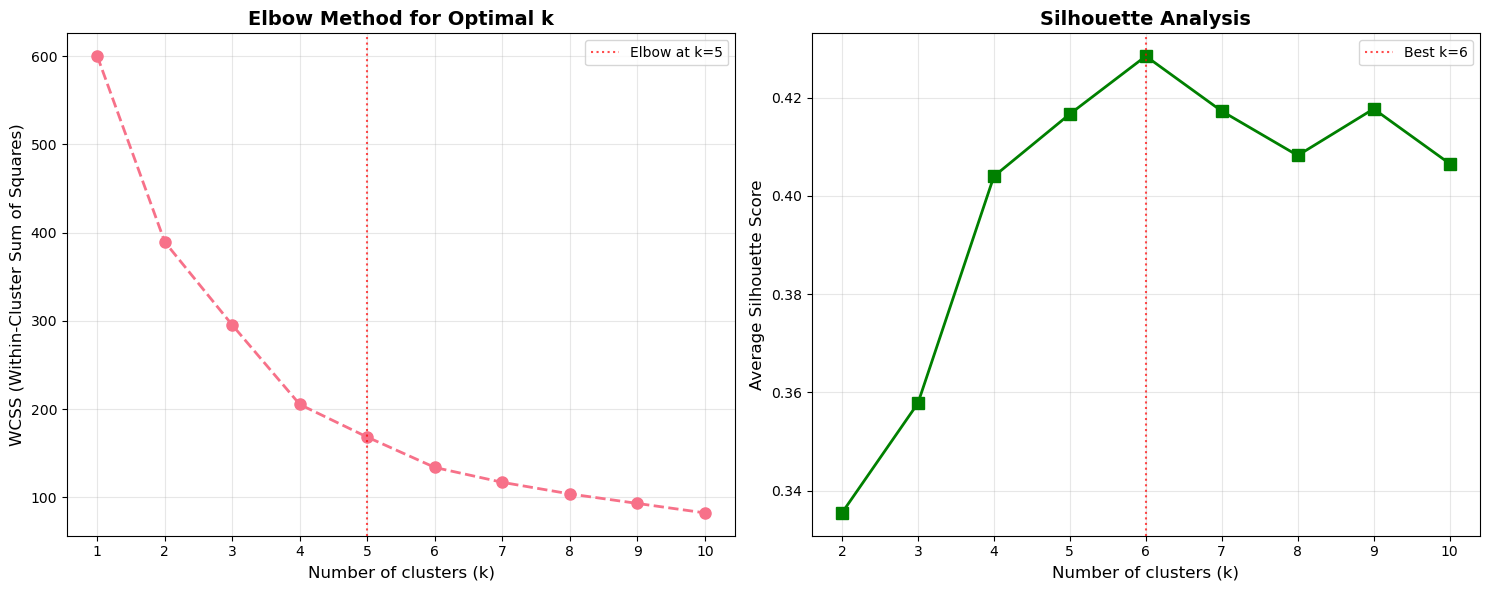

- Best silhouette score at k=6 with score=0.428


In [14]:
# Plot Elbow Method and Silhouette Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow Method Plot
ax1.plot(k_range, wcss, marker='o', linestyle='--', linewidth=2, markersize=8)
ax1.set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of clusters (k)', fontsize=12)
ax1.set_ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_range)

# Highlight the elbow point (k=5)
ax1.axvline(x=5, color='red', linestyle=':', alpha=0.7, label='Elbow at k=5')
ax1.legend()

# Silhouette Score Plot
k_range_sil = range(2, 11)
ax2.plot(k_range_sil, silhouette_scores, marker='s', linestyle='-', linewidth=2, markersize=8, color='green')
ax2.set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of clusters (k)', fontsize=12)
ax2.set_ylabel('Average Silhouette Score', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_range_sil)

# Highlight the best silhouette score
best_k = k_range_sil[np.argmax(silhouette_scores)]
ax2.axvline(x=best_k, color='red', linestyle=':', alpha=0.7, label=f'Best k={best_k}')
ax2.legend()

plt.tight_layout()
plt.show()


print(f"- Best silhouette score at k={best_k} with score={max(silhouette_scores):.3f}")


Analysis Results:
- Elbow method suggests k=5 as optimal
- Both methods support k=5 as a reasonable choice

### 5.2 K-Means Implementation with Optimal k

In [15]:
# Implement K-Means with k=5
optimal_k = 5
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df_processed['Cluster'] = cluster_labels

# Calculate final silhouette score
final_silhouette = silhouette_score(X_scaled, cluster_labels)

print(f"K-Means Clustering Results (k={optimal_k}):")
print(f"- Silhouette Score: {final_silhouette:.3f}")
print(f"- WCSS (Inertia): {kmeans_final.inertia_:.2f}")
print("\nCluster Distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"  Cluster {cluster}: {count} customers ({percentage:.1f}%)")

print("\nCluster Centers (in scaled space):")
centers_df = pd.DataFrame(kmeans_final.cluster_centers_, 
                         columns=features_for_clustering,
                         index=[f'Cluster {i}' for i in range(optimal_k)])
print(centers_df.round(3))

K-Means Clustering Results (k=5):
- Silhouette Score: 0.417
- WCSS (Inertia): 168.25

Cluster Distribution:
  Cluster 0: 20 customers (10.0%)
  Cluster 1: 54 customers (27.0%)
  Cluster 2: 40 customers (20.0%)
  Cluster 3: 39 customers (19.5%)
  Cluster 4: 47 customers (23.5%)

Cluster Centers (in scaled space):
             Age  Annual Income (k$)  Spending Score (1-100)
Cluster 0  0.531              -1.291                  -1.236
Cluster 1 -0.981              -0.743                   0.467
Cluster 2 -0.429               0.975                   1.216
Cluster 3  0.073               0.975                  -1.197
Cluster 4  1.205              -0.236                  -0.052


### 5.3 Cluster Visualization

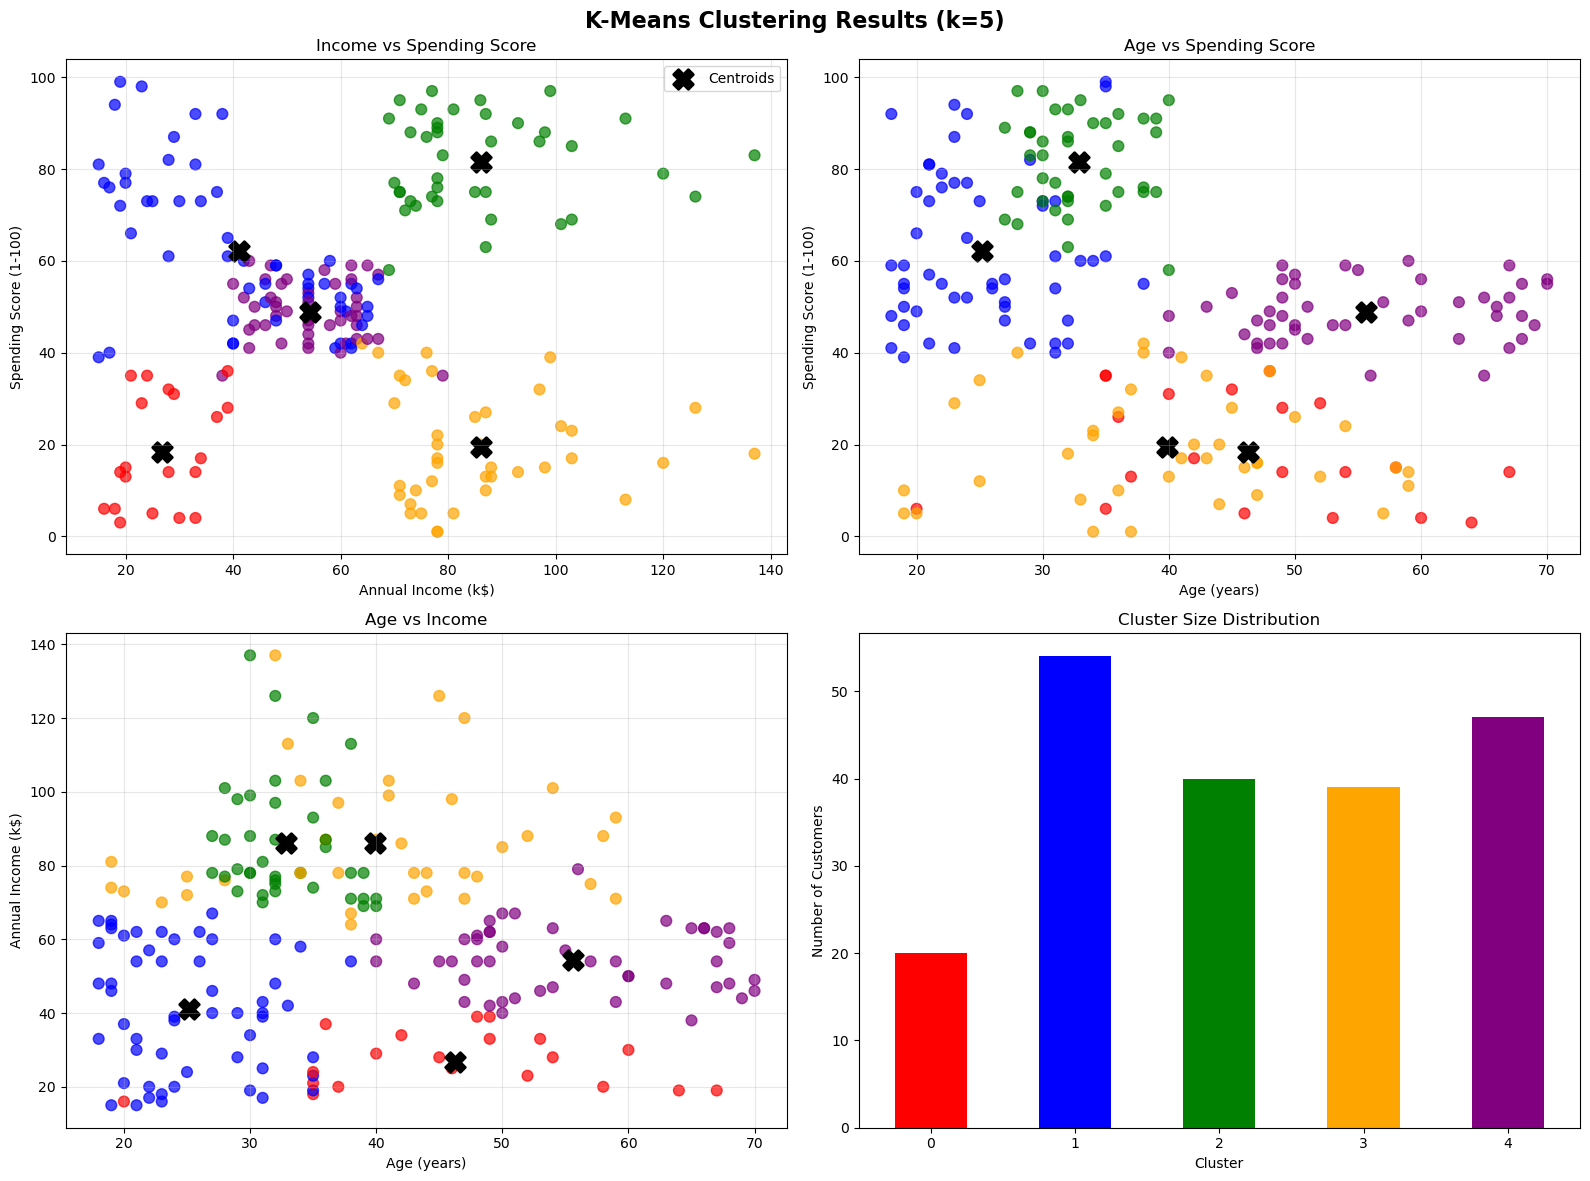

Cluster Color Legend:
  Cluster 0: Red
  Cluster 1: Blue
  Cluster 2: Green
  Cluster 3: Orange
  Cluster 4: Purple


In [16]:
# Create comprehensive cluster visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('K-Means Clustering Results (k=5)', fontsize=16, fontweight='bold')

# Define colors for clusters
colors = ['red', 'blue', 'green', 'orange', 'purple']
cluster_colors = [colors[label] for label in cluster_labels]

# Plot 1: Income vs Spending Score with clusters
scatter1 = axes[0,0].scatter(df_processed['Annual Income (k$)'], 
                            df_processed['Spending Score (1-100)'], 
                            c=cluster_colors, alpha=0.7, s=60)

# Plot centroids in original scale
centroids_original = scaler.inverse_transform(kmeans_final.cluster_centers_)
axes[0,0].scatter(centroids_original[:, 1], centroids_original[:, 2], 
                 c='black', marker='X', s=200, linewidths=2, label='Centroids')

axes[0,0].set_xlabel('Annual Income (k$)')
axes[0,0].set_ylabel('Spending Score (1-100)')
axes[0,0].set_title('Income vs Spending Score')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Age vs Spending Score with clusters
axes[0,1].scatter(df_processed['Age'], 
                 df_processed['Spending Score (1-100)'], 
                 c=cluster_colors, alpha=0.7, s=60)
axes[0,1].scatter(centroids_original[:, 0], centroids_original[:, 2], 
                 c='black', marker='X', s=200, linewidths=2)
axes[0,1].set_xlabel('Age (years)')
axes[0,1].set_ylabel('Spending Score (1-100)')
axes[0,1].set_title('Age vs Spending Score')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Age vs Income with clusters
axes[1,0].scatter(df_processed['Age'], 
                 df_processed['Annual Income (k$)'], 
                 c=cluster_colors, alpha=0.7, s=60)
axes[1,0].scatter(centroids_original[:, 0], centroids_original[:, 1], 
                 c='black', marker='X', s=200, linewidths=2)
axes[1,0].set_xlabel('Age (years)')
axes[1,0].set_ylabel('Annual Income (k$)')
axes[1,0].set_title('Age vs Income')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Cluster size distribution
cluster_counts.plot(kind='bar', ax=axes[1,1], color=colors[:optimal_k])
axes[1,1].set_title('Cluster Size Distribution')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Number of Customers')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Create a legend for cluster colors
print("Cluster Color Legend:")
for i, color in enumerate(colors[:optimal_k]):
    print(f"  Cluster {i}: {color.capitalize()}")

## 7. Cluster Analysis and Business Insights

### 7.1 K-Means Cluster Profiling

In [17]:
# Detailed cluster analysis for K-Means results
cluster_profiles = df_processed.groupby('Cluster').agg({
    'Age': ['mean', 'std', 'min', 'max'],
    'Annual Income (k$)': ['mean', 'std', 'min', 'max'],
    'Spending Score (1-100)': ['mean', 'std', 'min', 'max'],
    'Gender': lambda x: x.value_counts().to_dict()
}).round(2)

print("K-MEANS CLUSTER PROFILES")
print("=" * 50)

for cluster in range(optimal_k):
    cluster_data = df_processed[df_processed['Cluster'] == cluster]
    n_customers = len(cluster_data)
    
    print(f"\nCLUSTER {cluster} ({n_customers} customers - {(n_customers/len(df_processed)*100):.1f}%):")
    print("-" * 30)
    
    # Demographics
    avg_age = cluster_data['Age'].mean()
    avg_income = cluster_data['Annual Income (k$)'].mean()
    avg_spending = cluster_data['Spending Score (1-100)'].mean()
    
    print(f"Average Age: {avg_age:.1f} years")
    print(f"Average Income: ${avg_income:.1f}k")
    print(f"Average Spending Score: {avg_spending:.1f}/100")
    
    # Gender distribution
    gender_dist = cluster_data['Gender'].value_counts()
    print(f"Gender: {dict(gender_dist)}")
    
    # Business interpretation
    if avg_income > 70 and avg_spending > 70:
        segment_name = "💎 High-Value Customers (Premium Segment)"
        strategy = "Focus on luxury products, VIP services, and premium experiences"
    elif avg_income > 70 and avg_spending < 40:
        segment_name = "💰 Conservative High Earners (Potential Growth)"
        strategy = "Target with premium value propositions and exclusive offers"
    elif avg_income < 40 and avg_spending < 40:
        segment_name = "🏪 Budget-Conscious Customers (Price Sensitive)"
        strategy = "Focus on discounts, promotions, and value-for-money products"
    elif avg_spending > 70:
        segment_name = "🛍️ High Spenders (Lifestyle Focused)"
        strategy = "Target with trendy products, social media marketing, and experiences"
    else:
        segment_name = "👥 Moderate Customers (Balanced Approach)"
        strategy = "Balanced marketing with both value and quality emphasis"
    
    print(f"Segment: {segment_name}")
    print(f"Strategy: {strategy}")

print("\n" + "=" * 70)

K-MEANS CLUSTER PROFILES

CLUSTER 0 (20 customers - 10.0%):
------------------------------
Average Age: 46.2 years
Average Income: $26.8k
Average Spending Score: 18.4/100
Gender: {'Female': 12, 'Male': 8}
Segment: 🏪 Budget-Conscious Customers (Price Sensitive)
Strategy: Focus on discounts, promotions, and value-for-money products

CLUSTER 1 (54 customers - 27.0%):
------------------------------
Average Age: 25.2 years
Average Income: $41.1k
Average Spending Score: 62.2/100
Gender: {'Female': 32, 'Male': 22}
Segment: 👥 Moderate Customers (Balanced Approach)
Strategy: Balanced marketing with both value and quality emphasis

CLUSTER 2 (40 customers - 20.0%):
------------------------------
Average Age: 32.9 years
Average Income: $86.1k
Average Spending Score: 81.5/100
Gender: {'Female': 22, 'Male': 18}
Segment: 💎 High-Value Customers (Premium Segment)
Strategy: Focus on luxury products, VIP services, and premium experiences

CLUSTER 3 (39 customers - 19.5%):
------------------------------


### 7.2 Spending Score Analysis by Cluster

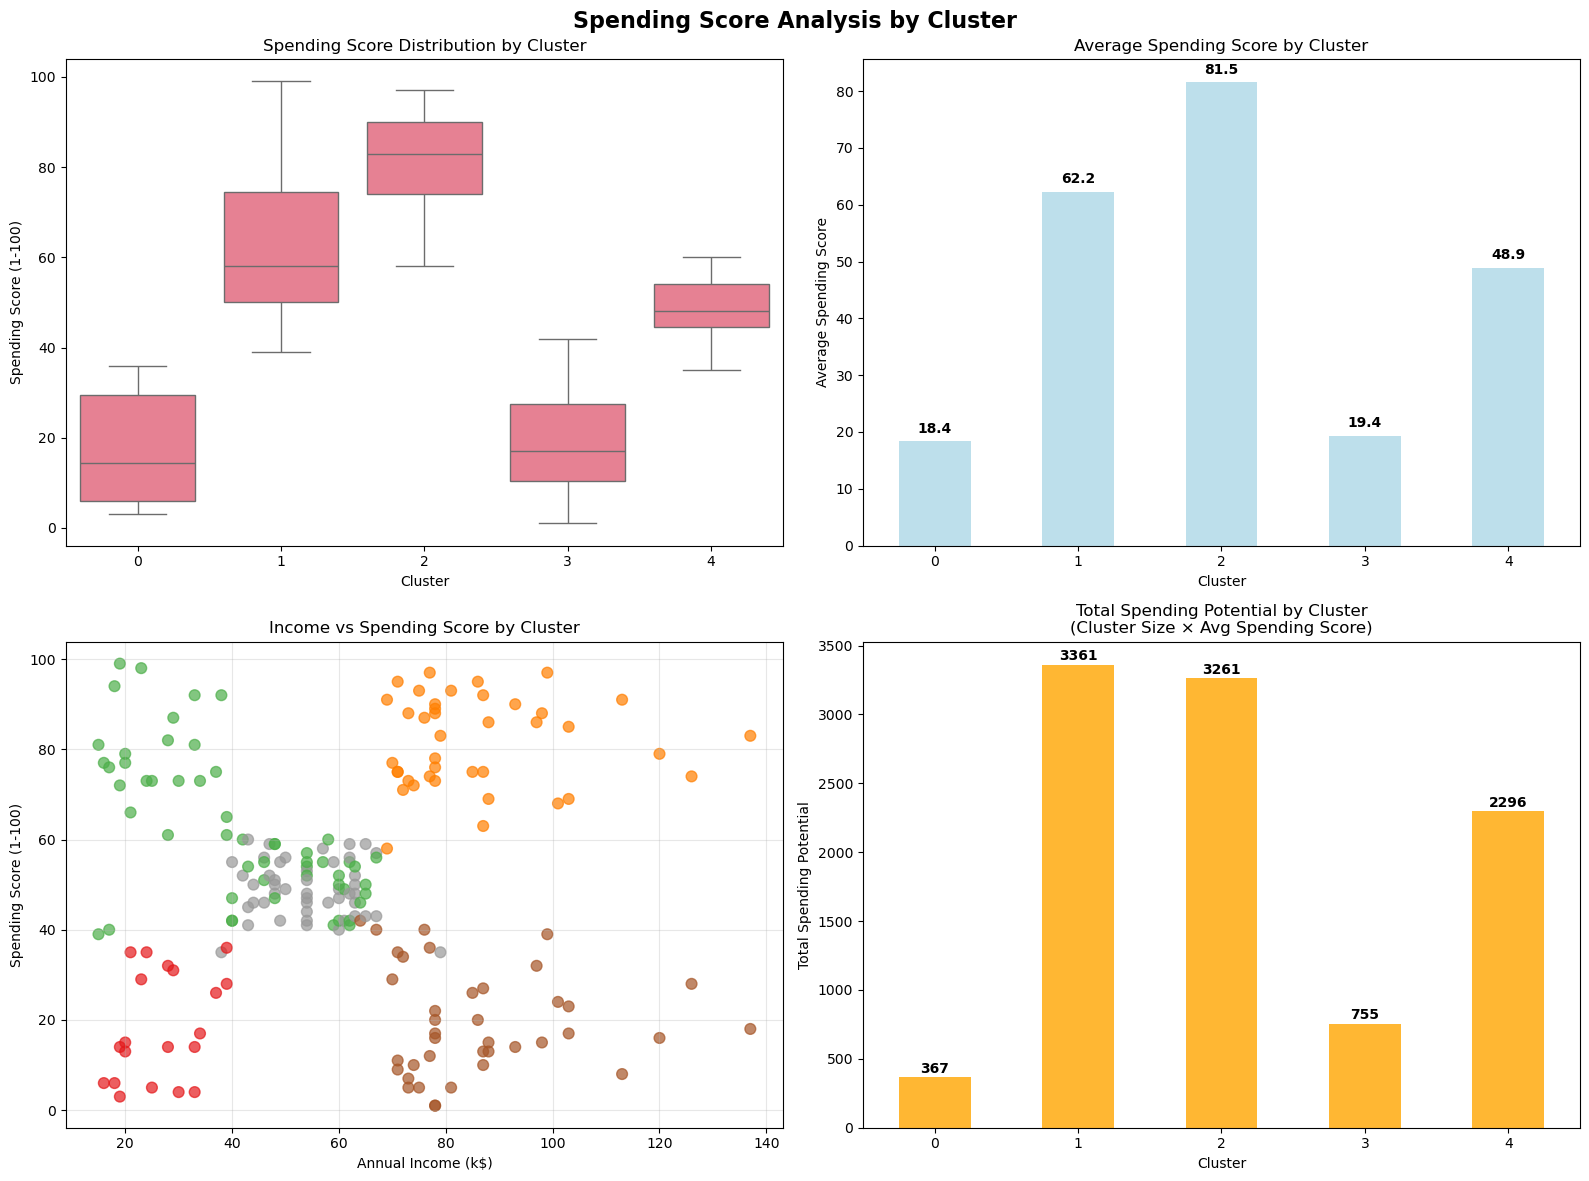


SPENDING SCORE SUMMARY BY CLUSTER:
        Spending Score (1-100)                       Annual Income (k$)
                         count   mean    std min max               mean
Cluster                                                                
0                           20  18.35  11.94   3  36              26.75
1                           54  62.24  16.60  39  99              41.09
2                           40  81.53  10.00  58  97              86.10
3                           39  19.36  11.61   1  42              86.10
4                           47  48.85   6.30  35  60              54.38

KEY INSIGHTS:
- Highest average spending: Cluster 2 (81.5/100)
- Lowest average spending: Cluster 0 (18.4/100)
- Highest total potential: Cluster 1 (3361 total points)
- Spending score range: 1-99


In [18]:
# Detailed spending score analysis as requested
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Spending Score Analysis by Cluster', fontsize=16, fontweight='bold')

# Box plot of spending scores by cluster
sns.boxplot(data=df_processed, x='Cluster', y='Spending Score (1-100)', ax=axes[0,0])
axes[0,0].set_title('Spending Score Distribution by Cluster')
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_ylabel('Spending Score (1-100)')

# Average spending score by cluster
avg_spending_by_cluster = df_processed.groupby('Cluster')['Spending Score (1-100)'].mean()
avg_spending_by_cluster.plot(kind='bar', ax=axes[0,1], color='lightblue', alpha=0.8)
axes[0,1].set_title('Average Spending Score by Cluster')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Average Spending Score')
axes[0,1].tick_params(axis='x', rotation=0)

# Add value labels on bars
for i, v in enumerate(avg_spending_by_cluster):
    axes[0,1].text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# Spending score vs Income colored by cluster
scatter = axes[1,0].scatter(df_processed['Annual Income (k$)'], 
                           df_processed['Spending Score (1-100)'], 
                           c=df_processed['Cluster'], 
                           s=60, alpha=0.7, cmap='Set1')
axes[1,0].set_xlabel('Annual Income (k$)')
axes[1,0].set_ylabel('Spending Score (1-100)')
axes[1,0].set_title('Income vs Spending Score by Cluster')
axes[1,0].grid(True, alpha=0.3)

# Cluster size and total spending potential
cluster_stats = df_processed.groupby('Cluster').agg({
    'Spending Score (1-100)': ['count', 'mean', 'sum'],
    'Annual Income (k$)': 'mean'
}).round(1)

# Calculate total spending potential (size * avg_spending)
cluster_potential = df_processed.groupby('Cluster').agg({
    'Spending Score (1-100)': lambda x: len(x) * x.mean()
})['Spending Score (1-100)']

cluster_potential.plot(kind='bar', ax=axes[1,1], color='orange', alpha=0.8)
axes[1,1].set_title('Total Spending Potential by Cluster\n(Cluster Size × Avg Spending Score)')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Total Spending Potential')
axes[1,1].tick_params(axis='x', rotation=0)

# Add value labels
for i, v in enumerate(cluster_potential):
    axes[1,1].text(i, v + 10, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary table of spending characteristics
spending_summary = df_processed.groupby('Cluster').agg({
    'Spending Score (1-100)': ['count', 'mean', 'std', 'min', 'max'],
    'Annual Income (k$)': 'mean'
}).round(2)

print("\nSPENDING SCORE SUMMARY BY CLUSTER:")
print(spending_summary)

print("\nKEY INSIGHTS:")
highest_spending_cluster = avg_spending_by_cluster.idxmax()
lowest_spending_cluster = avg_spending_by_cluster.idxmin()
largest_potential_cluster = cluster_potential.idxmax()

print(f"- Highest average spending: Cluster {highest_spending_cluster} ({avg_spending_by_cluster[highest_spending_cluster]:.1f}/100)")
print(f"- Lowest average spending: Cluster {lowest_spending_cluster} ({avg_spending_by_cluster[lowest_spending_cluster]:.1f}/100)")
print(f"- Highest total potential: Cluster {largest_potential_cluster} ({cluster_potential[largest_potential_cluster]:.0f} total points)")
print(f"- Spending score range: {df_processed['Spending Score (1-100)'].min()}-{df_processed['Spending Score (1-100)'].max()}")